# 2-mode Grover's search algorithm

We implement in this notebook a 2-mode optical realization of Grover's search algorithm, based on Kwiat et al. (2000). Grover’s search algorithm: An optical approach. [Journal of Modern Optics](https://doi.org/10.1080/09500340008244040), 47(2–3), 257–266.

## Introduction

### Motivation

Searching for a specific item (called the marked item) in an unstructured list of $N$ items requires $O(N)$ accesses to the list classically. Grover showed in 1996 that is possible for a quantum computer to achieve this using only $O\left(\sqrt{N}\right)$ iterations.

### Algorithm summary

For a list of size $N$, Grover's algorithm requires $\log (N)$ qubits. The algorithm starts by setting each qubit in the superposition state $\frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)$. Then it applies $O\left(\sqrt{N}\right)$ iterations of a subroutine called inversion-about-mean, whose goal is to skew this initial uniform superposition state towards the desired marked state such the probability of measuring the marked state is amplified. This subroutine requires the application of an oracle unitary, which applies a relative $\pi$ phase shift only to the quantum state encoding the item we are looking for in the database.

### Kwiat et al. implementation details

The optical implementation of Kwiat et al. uses the polarization and path degree of freedom of a single beam to achieve a 2-qubit optical implementation of Grover's search algorithm. Although $N=4$ here, calculations show that only a single application of the inversion-about-mean subroutine is required.

In an effort to reduce the number of optical components used in the experimental setup, the authors work with a compiled version of the circuit, which we will reproduce here using Perceval.

## Perceval implementation

### Initialisation

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import perceval as pcvl
from perceval.algorithm import Analyzer

We create in Perceval a circuit with two spatial modes, $a$ and $b$ denoting resapectively the lower and upper spatial modes. For clarity, the different equivalent encodings for each of the four basis states are given below in order:
- marked item encoding: $\left|"00"\right\rangle$, $\left|"01"\right\rangle$, $\left|"10"\right\rangle$, $\left|"11"\right\rangle$
- Kwiat et al. path and polarization encoding: $\left|aH\right\rangle$, $\left|aV\right\rangle$, $\left|bH\right\rangle$, $\left|bV\right\rangle$
- Perceval path and polarization encoding: $\left|0, 1:H\right\rangle$, $\left|0, 1:V\right\rangle$, $\left|1:H, 0\right\rangle$, $\left|1:V, 0\right\rangle$

We first define these states and their mode equivalent in Perceval:

In [2]:
states = [pcvl.BasicState("|0,{P:H}>"),
          pcvl.BasicState("|0,{P:V}>"),
          pcvl.BasicState("|{P:H},0>"),
          pcvl.BasicState("|{P:V},0>"),
         ]

states_modes = [
    pcvl.BasicState([0, 0, 0, 1]),
    pcvl.BasicState([0, 0, 1, 0]),
    pcvl.BasicState([0, 1, 0, 0]),
    pcvl.BasicState([1, 0, 0, 0])
]

We use the following unitary matrix to represent the beamsplitters:

In [3]:
bsry = pcvl.BS.Ry()
pcvl.pdisplay(bsry.U)

<IPython.core.display.Math object>

The half-wave plates are defined in the article as:

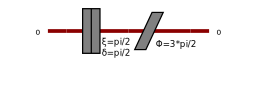

In [4]:
def HWP(xsi):
    hwp = pcvl.Circuit(m=1)
    hwp.add(0, pcvl.HWP(xsi)).add(0, pcvl.PS(-math.pi/2))
    return hwp

pcvl.pdisplay(HWP(math.pi/2))

### Circuit Construction

We divide the compiled circuit of Kwiat et al. in three parts: [state initialization](#state-initialization-circuit), [oracle](#oracle) and [inversion about mean](#inversion-about-mean). However, due to the compilation, each individual part does not act exactly as described in the introduction.


#### State initialization circuit

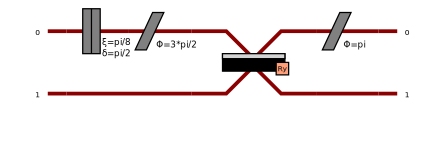

In [5]:
init_circuit = (pcvl.Circuit(m=2, name="Initialization")
                // HWP(math.pi / 8)
                // bsry
                // pcvl.PS(-math.pi))

pcvl.pdisplay(init_circuit)

#### Oracle

The oracle circuit can be initialised so that any one of the four list elements are marked. This is controlled via the integer parameter $mark \in [0, 3]$.

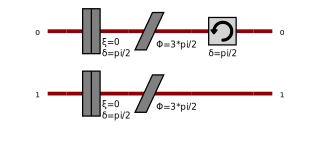

In [6]:
def oracle(mark: int):
    """Values 0, 1, 2 and 3 for parameter 'mark' respectively mark the elements "00", "01", "10" and "11" of the list."""
    oracle_circuit = pcvl.Circuit(m=2, name='Oracle')
    # The following dictionary translates n into the corresponding component settings
    oracle_dict = {0: (1, 0), 1: (0, 1), 2: (1, 1), 3: (0, 0)}
    PC_state, LC_state = oracle_dict[mark]
    # Mode b
    if PC_state == 1:
        oracle_circuit //= HWP(0)
    oracle_circuit.add(0, pcvl.PR(math.pi/2))
    if LC_state == 1:
        oracle_circuit //= HWP(0)
    # Mode a
    if LC_state == 1:
        oracle_circuit //= (1, HWP(0))
    if PC_state == 1:
        oracle_circuit //= (1, HWP(0))
    return oracle_circuit

pcvl.pdisplay(oracle(0))

#### Inversion about mean

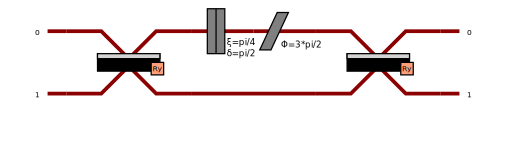

In [7]:
inversion_circuit = (pcvl.Circuit(m=2, name='Inversion')
                     // bsry
                     // HWP(math.pi / 4)
                     // bsry)

pcvl.pdisplay(inversion_circuit)

#### Detection

The article also uses a detection circuit of the form:

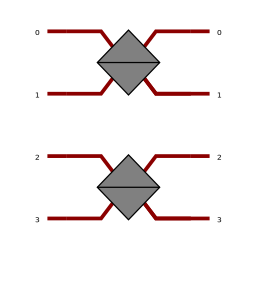

In [8]:
detection_circuit = pcvl.Circuit(m=4, name='Detection')
detection_circuit.add((0, 1), pcvl.PBS())
detection_circuit.add((2, 3), pcvl.PBS())

pcvl.pdisplay(detection_circuit)

However, Perceval allows us to filter out the photon's polarization state, meaning that there is no need to expand the circuit to four output spatial modes.

For now, we will need this particular circuit.

#### Final circuit setup 

As above, the value of parameter 'mark' indicates which element of the list needs to be found.

Grover optical circuit for searching database element "00":


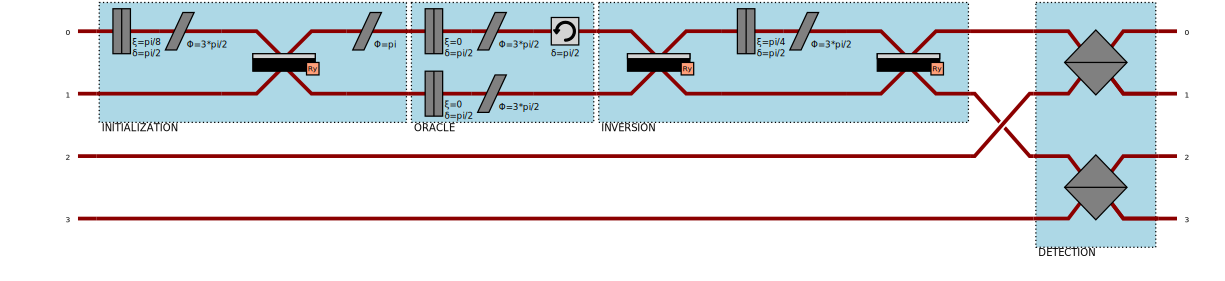

In [9]:
def grover_circuit(mark: int):
    grover = pcvl.Circuit(m=4, name='Grover')
    grover.add(0, init_circuit).add(0, oracle(mark)).add(0, inversion_circuit)
    grover.add(1, pcvl.PERM([1, 0])).add(0, detection_circuit)
    return grover

print('Grover optical circuit for searching database element "00":')
pcvl.pdisplay(grover_circuit(0), recursive=True)

## Grover algorithm execution

We can finally simulate Grover's algorithm for marked database elements "00", "01", "10" and "11".

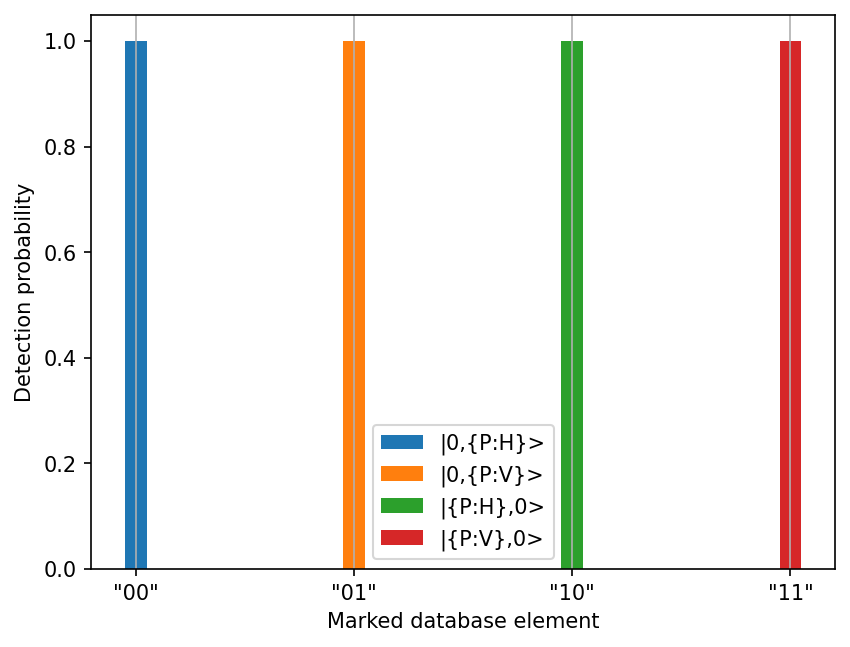

In [10]:
# Circuit simulation
input_state = pcvl.BasicState("|{P:H},0, 0, 0>")
results_list = []  # probability amplitudes storage

for mark in range(4):
    p = pcvl.Processor("SLOS", grover_circuit(mark))
    a = Analyzer(p, input_states=[input_state], output_states=states_modes)
    results_list.append(a.distribution[0])

# Plot data
labels = ['"00"', '"01"', '"10"', '"11"']
x = np.arange(4)  # label locations
    
fig, ax = plt.subplots(dpi=150)
for result, state in zip(results_list, states):
    ax.bar(x, result.real, 0.1, label=str(state))

ax.set_xlabel('Marked database element')
ax.set_ylabel('Detection probability')    
ax.set_xticks(x, labels)
ax.legend()
ax.grid(True, axis='x')
plt.show()

As demonstrated by the graph above, Grover's algorithm indeed finds the marked database element!

## Reference

> Kwiat et al. Grover’s search algorithm: An optical approach. [Journal of Modern Optics](https://doi.org/10.1080/09500340008244040), 47(2–3), 257–266 (2000).
